# Hydroglaciology

## Importing modules and libraries

### Importing libraries

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import datetime
import time
import obspy

### Give access to modules folder

In [3]:
import os, sys
modules = os.path.abspath('Modules//')
if modules not in sys.path:
    sys.path.append(modules)

### Importing homemade python modules

In [4]:
from hydronoise import hydronoise_plot
from hydronoise import amp_noise_mean_median

In [5]:
from normalize import normalize

## Importing data from gauging station and temperature

### Specify the folder of temperature and discharge data

In [6]:
direct = 'D:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V299\Vdv_data_20221120143940'

### Importing temperature and discharge data

In [7]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

### Plotting temperature and discharge data

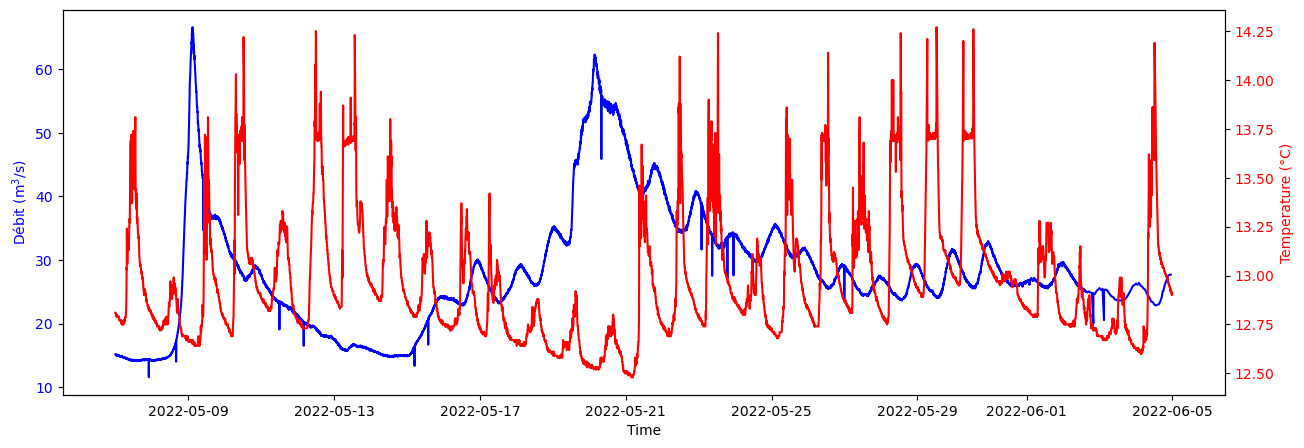

In [8]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Temperature (°C)', color = 'red') 
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red')
ax2.tick_params(axis ='y', labelcolor = 'red') 
 
# Show plot

plt.show()

In [9]:
n=1
max_temp = []
max_velos = []
for i in range(len(temp_time)):
    #print(i)
    if temp_time[0] == temp_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(temp[i-288:i]) + (i-288)
        max_temp.append(temp_time[idx])
        #print(i-456)
        n+= 1
        
n=1        
for i in range(len(gauging_time)):
    #print(i)
    if gauging_time[0] == gauging_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(gauging_velos[i-289:i]) + (i-289)
        max_velos.append(gauging_time[idx])
        n+= 1
    
delta_time = np.subtract(max_velos, max_temp)

for i in range(len(delta_time)) :
    delta_time[i] = delta_time[i]/datetime.timedelta(hours=1)
    

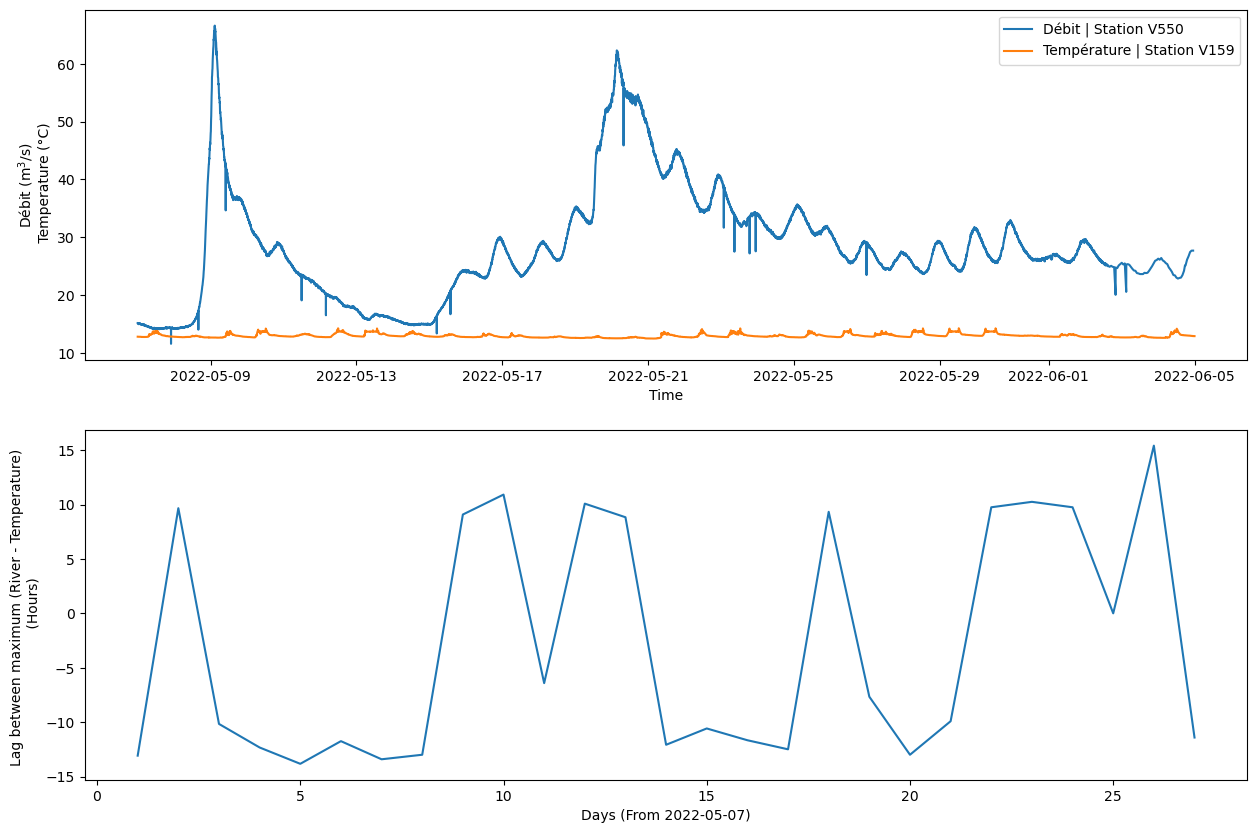

In [10]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

day = list(range(1,28))
#plt.plot(day,max_temp.date())
#plt.plot(day,max_velos.time())
plt.plot(day, delta_time[:27])
plt.xlabel('Days (From 2022-05-07)')
plt.ylabel('Lag between maximum (River - Temperature) \n (Hours)')
plt.show()

### Importing temperature and precipitation from NetCFDmport netCDF4

In [12]:
import netCDF4 as nc

In [13]:
import numpy as np

# Thanks to unutbu

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [14]:
data = './temp-precip/data.nc'
ds = nc.Dataset(data)

In [15]:
print(ds)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    Conventions: CF-1.6
    history: 2023-03-21 13:32:36 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/cfafa64b-313a-4352-98fa-1bb1822aca28-adaptor.mars.internal-1679405550.6413646-16758-6-tmp.nc /cache/tmp/cfafa64b-313a-4352-98fa-1bb1822aca28-adaptor.mars.internal-1679405128.2134974-16758-4-tmp.grib
    dimensions(sizes): longitude(141), latitude(61), time(744)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 time(time), int16 t2m(time, latitude, longitude), int16 sf(time, latitude, longitude), int16 tsn(time, latitude, longitude), int16 tp(time, latitude, longitude)
    groups: 


In [16]:
print(ds.__dict__)

{'Conventions': 'CF-1.6', 'history': '2023-03-21 13:32:36 GMT by grib_to_netcdf-2.24.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -S param -o /cache/tmp/cfafa64b-313a-4352-98fa-1bb1822aca28-adaptor.mars.internal-1679405550.6413646-16758-6-tmp.nc /cache/tmp/cfafa64b-313a-4352-98fa-1bb1822aca28-adaptor.mars.internal-1679405128.2134974-16758-4-tmp.grib'}


In [17]:
LON = list(ds['longitude'][:])
LAT = list(ds['latitude'][:])

prcp = np.array(ds['tp'][:])
temp = np.array(ds['t2m'][:])

In [18]:
time = np.array(ds['time'][:])
origin = datetime.datetime(1900,1,1)
T = []
for h in time :
    T.append(origin + datetime.timedelta(hours = float(h)))

In [19]:
lat = 64.209114
lon = -17.832866
PREP = []
TEMP = []

idxLat = find_nearest(LAT, lat)
idxLong = find_nearest(LON, lon)

for t in range(len(time)) :
    PREP.append(float(prcp[t][idxLat][idxLong]))
    TEMP.append(float(temp[t][idxLat][idxLong]))

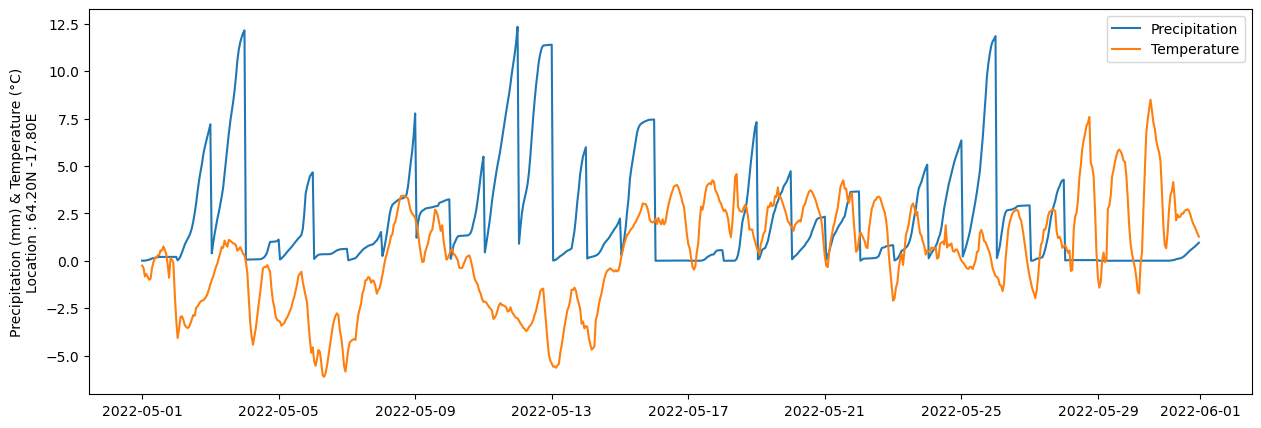

In [20]:
plt.figure(figsize=(15,5))
plt.plot(T,np.array(PREP)*1000, label='Precipitation')
plt.plot(T,np.array(TEMP)-273.25, label='Temperature')
plt.ylabel('Precipitation (mm) & Temperature (°C)\nLocation : %0.2fN %0.2fE' %(LAT[idxLat], LON[idxLong]))

plt.legend()

### GPS Cauldron

In [21]:
rfile = 'D:/MEMOIRE/HYDRO/cauldron/gps-cauldron.txt'

In [22]:
with open(rfile) as file :
    readcsv = csv.reader(file, delimiter='\t')
    line = 0
    for row in readcsv :
        print(row)

['#yyyy/mm/dd HH:MM:SS.SSS          dN[mm] DN[mm]', 'dE[mm] DE[mm]', 'dU[mm]  DU[mm]']
[' 2005/10/02 12:00:00', '  -1.06    2.62', '  -0.75    1.83', '   5.36    8.08']
[' 2005/10/03 12:00:00', '  -0.62    1.80', '  -0.93    1.51', '   1.77    5.82']
[' 2005/10/10 12:00:00', '  -1.03    2.16', '   0.10    1.71', '   2.72    6.74']
[' 2005/10/11 12:00:00', '  -1.01    1.82', '  -0.23    1.52', '  -3.67    5.85']
[' 2005/10/12 12:00:00', '   0.23    1.88', '  -0.49    1.57', '  -3.04    6.07']
[' 2005/10/13 12:00:00', '  -0.36    1.93', '   1.73    1.61', '   0.56    6.28']
[' 2005/10/14 12:00:00', '   1.53    2.22', '  -0.57    1.84', '  -2.42    7.25']
[' 2005/10/15 12:00:00', '   2.81    2.91', '  -1.90    2.38', '  22.06    9.54']
[' 2005/10/16 12:00:00', '   1.87    2.16', '  -1.16    1.80', '   1.61    7.03']
[' 2005/10/17 12:00:00', '   0.57    1.93', '   1.96    1.60', '   4.70    6.23']
[' 2005/10/18 12:00:00', '   0.22    1.78', '   1.39    1.48', '   2.77    5.72']
[' 2005/10/

# Confronting wave with water : PPSD

## Modules and fonctions

In [23]:
from obspy.signal import PPSD

In [24]:
"""
Fonction qui fait la mediane sur une succession de points
output[0] = median
output[1] = std
output[2] = time
"""
def medGPS_linear(rL, time,nbrpt = None) :
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[]] #0 is median
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            output[0].append(np.median(rL[i:i+nbrpt]))
            output[1].append(np.std(rL[i:i+nbrpt]))
            output[2].append(time[i])
    return np.array(output)

In [25]:
def RMS_smoothing(rL, time,nbrpt = None) :
    rL = np.array(rL)
    if nbrpt == None :
        nbrpt = 8
    output = [[],[],[],[]] #0 is rms
    for i in range(len(rL)-nbrpt) :
        if i < len(rL) - nbrpt :
            rms = np.sqrt(np.sum(rL[i:i+nbrpt]**2)/nbrpt)
            mode = scipy.stats.mode(rL[i:i+nbrpt])[0][0]
            hist, bin_edges = np.histogram(rL[i:i+nbrpt], density=True)
            mode_np = hist.max()
            output[0].append(rms)
            output[1].append(mode)
            output[2].append(mode_np)
            output[3].append(time[i])
    return np.array(output)

In [26]:
stt = '20773'

In [27]:
paz_counts = {'gain': 3355.4428,
       'poles': [(-22.2111-22.2178j),(-22.2111+22.2178j)],
       'sensitivity': 4910675.0731663825,
       'zeros': [0j, 0j]}

In [28]:
rot = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
test = obspy.read(rot+'4530%s.3.2022.05.08.00.00.00.000.Z.miniseed'%stt)
tr = test.select(id="SS.%s..DPZ"%stt)[0]
#inv =  obspy.read_inventory(rot+'VI.hus..HHZ.D.2022.007')
print(test)

1 Trace(s) in Stream:
SS.20773..DPZ | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 250.0 Hz, 21600001 samples


In [29]:
#test2 = obspy.read(rot+'453020739.5.2022.05.10.00.00.00.000.Z.miniseed')

In [30]:
ppsd = PPSD(tr.stats, paz_counts,ppsd_length=5*60,period_limits=[0.03,1])

In [31]:
fileroot= os.listdir(rot)

In [32]:
startnumber = 3
endnumber = 3+9
rr = list(range(startnumber, endnumber))
station = '4530%s' %(stt)
i=0
for file in fileroot :
    if file.startswith(station) and file.endswith('.Z.miniseed') :
        decoup = file.split('.')
        if startnumber <= float(decoup[1]) <= endnumber :
            stt = obspy.read(rot+file)
            ppsd.add(stt)
            print('Done %s' %file)


Done 453020773.10.2022.05.15.00.00.00.000.Z.miniseed
Done 453020773.11.2022.05.16.00.00.00.000.Z.miniseed
Done 453020773.12.2022.05.17.00.00.00.000.Z.miniseed
Done 453020773.3.2022.05.08.00.00.00.000.Z.miniseed
Done 453020773.4.2022.05.09.00.00.00.000.Z.miniseed
Done 453020773.5.2022.05.10.00.00.00.000.Z.miniseed
Done 453020773.6.2022.05.11.00.00.00.000.Z.miniseed
Done 453020773.7.2022.05.12.00.00.00.000.Z.miniseed
Done 453020773.8.2022.05.13.00.00.00.000.Z.miniseed
Done 453020773.9.2022.05.14.00.00.00.000.Z.miniseed


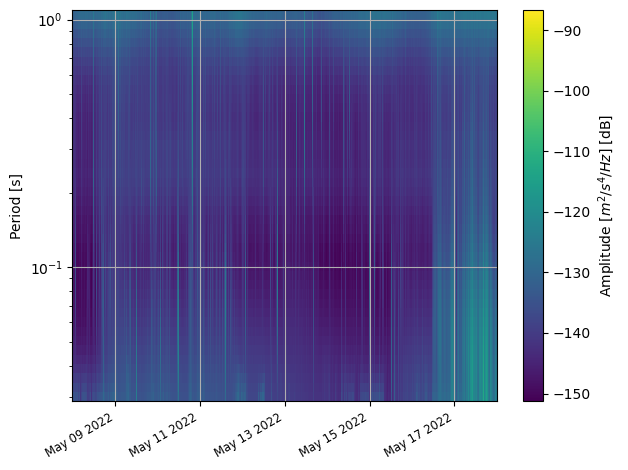

In [42]:
ppsd.plot_spectrogram()

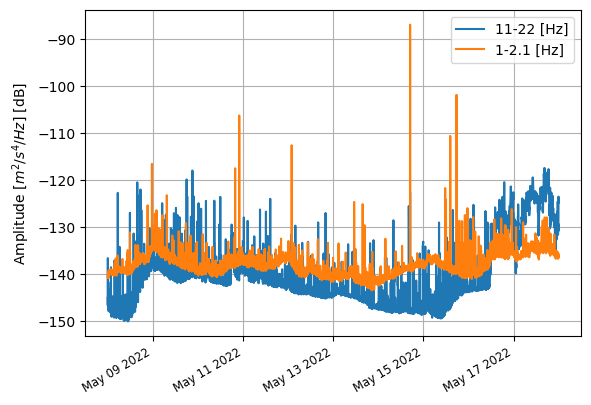

In [43]:
ppsd.plot_temporal([1/15,0.7])

In [44]:
Pwater = ppsd.extract_psd_values(0.7)[0]
Psed = ppsd.extract_psd_values(1/15)[0]
T = ppsd.times_processed

In [45]:
sPwater = RMS_smoothing(Pwater, T)
sPsed = RMS_smoothing(Psed, T)
medPwater = medGPS_linear(Pwater, T, nbrpt=8)

C:\Users\julie\AppData\Local\Temp\ipykernel_13120\1967593916.py:9: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = scipy.stats.mode(rL[i:i+nbrpt])[0][0]


[]

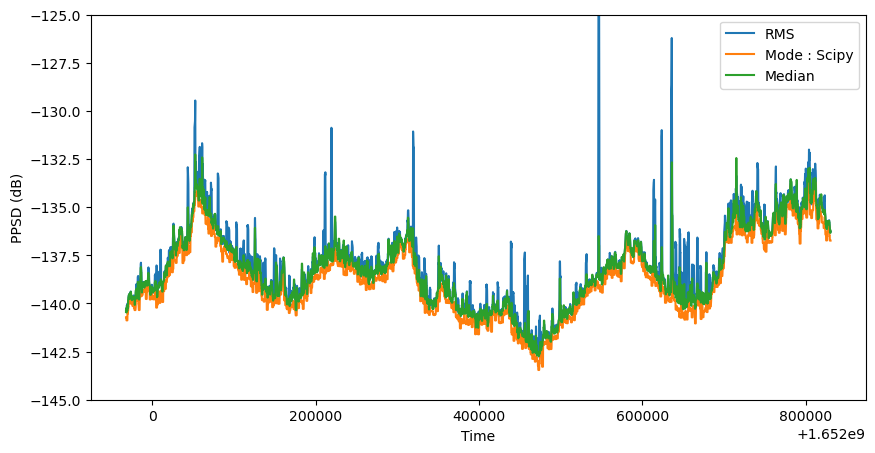

In [49]:
plt.figure(figsize = (10,5))

plt.plot(sPwater[3],-sPwater[0],label='RMS')
plt.plot(sPwater[3], sPwater[1],label='Mode : Scipy')
#plt.plot(sPwater[3], sPwater[2],label='Mode : np.hist')
#plt.plot(T,Pwater, label='RAW')
plt.plot(medPwater[2],medPwater[0],label='Median')
plt.ylabel('PPSD (dB)')
plt.xlabel('Time')
plt.ylim(-145,-125)
plt.legend()
plt.plot()

In [38]:
Tdate = np.array(sPwater[3], dtype='datetime64[ms]')

In [39]:
df = pd.read_csv('./temp_pos_nodes/temp_20773.csv')

In [40]:
temp_time = np.array(df.TIME, dtype='datetime64[ms]')
temp = np.array(df.TEMPERATURE)

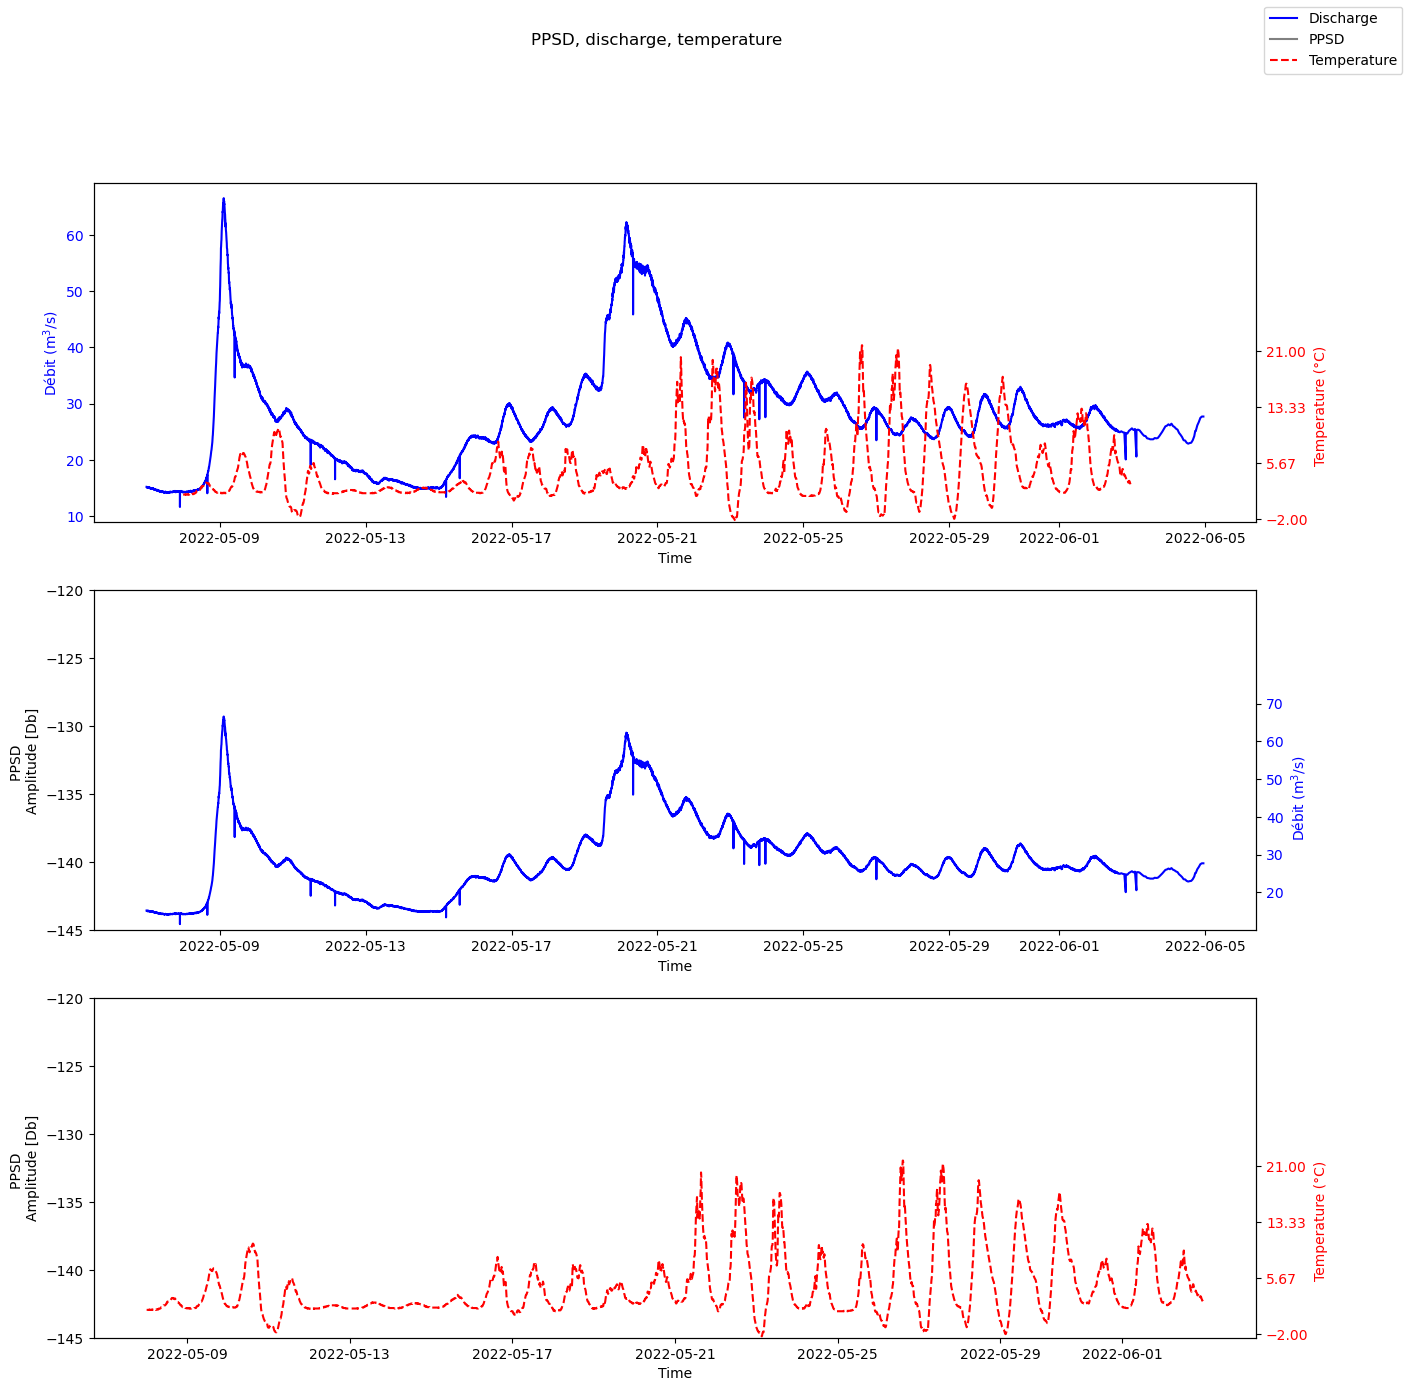

In [41]:
hydronoise_plot(gauging_time, gauging_velos,temp_time, temp, Tdate, sPwater[2], Yax_noise='PPSD \nAmplitude [Db]',limit=(-145,-120))

## Determining the periodicity of the signals
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

In [21]:
from period_finder import period_temp_discharge_noise

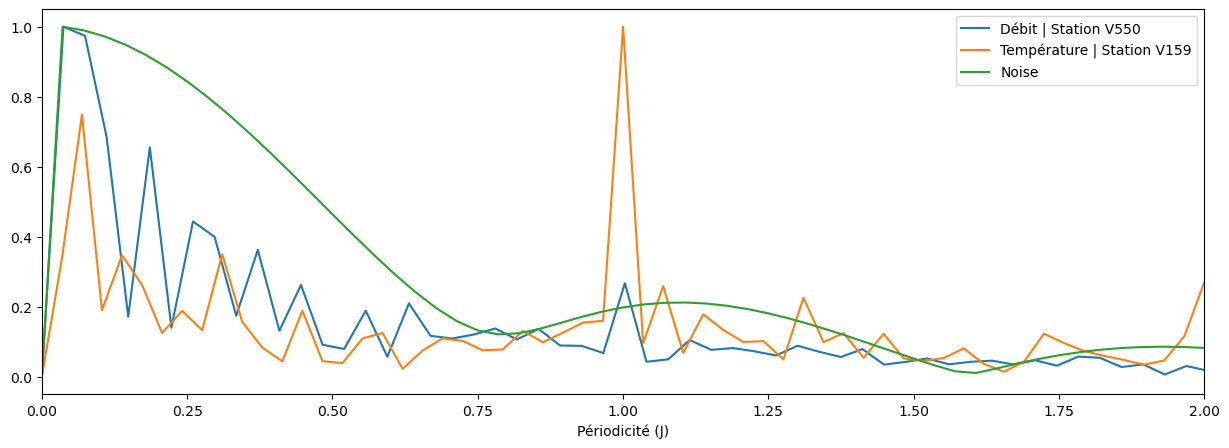

In [25]:
period_temp_discharge_noise(temp, 288, gauging_velos, 288, medianall739, 24*3)

## Determining the Pw and Pb Ratio


In [46]:
ggtime = np.array(gauging_time, dtype= 'datetime64[ms]')

In [47]:
bintime = np.in1d(ggtime, Tdate)

In [48]:
disPW = np.extract(bintime,gauging_velos)

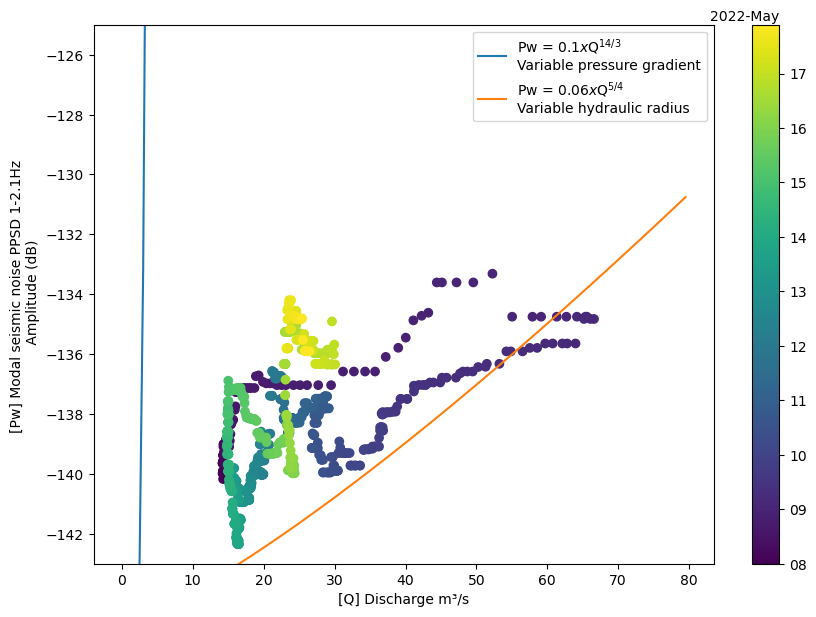

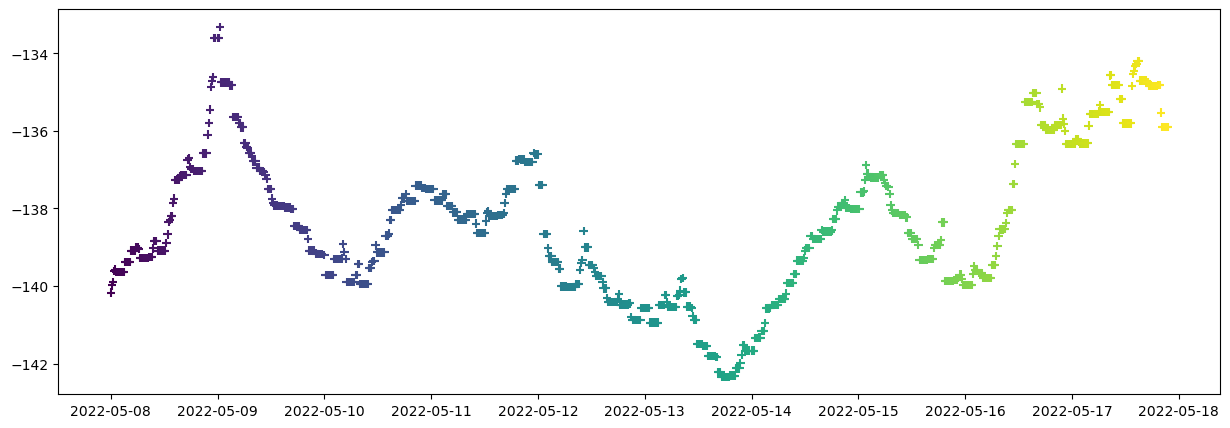

In [49]:
import matplotlib.dates as mdates
plt.figure(figsize=(10,7))

plt.scatter(disPW, sPwater[2],c=mdates.date2num(Tdate))
disModel = np.arange(0,100,10)

cb = plt.colorbar()
loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))

L = np.arange(0,80,.5)

p1 = .1*L**(14/3)-150
p2 = .06*L**(5/4)-145

plt.plot(L,p1, label='Pw = 0.1$x$Q$^{14/3}$ \nVariable pressure gradient')
plt.plot(L,p2, label='Pw = 0.06$x$Q$^{5/4}$ \nVariable hydraulic radius')
plt.ylim(-143,-125)
plt.legend()


plt.ylabel('[Pw] Modal seismic noise PPSD 1-2.1Hz \n Amplitude (dB)')
plt.xlabel('[Q] Discharge m³/s')

plt.show()

plt.figure(figsize=(15,5))
plt.scatter(Tdate,sPwater[2],c=Tdate,marker='+')
plt.show()
#plt.scatter(ntime,np.array(Psed)+50,c=ntime)

In [50]:
len(Psed), len(Pwater)

(950, 950)

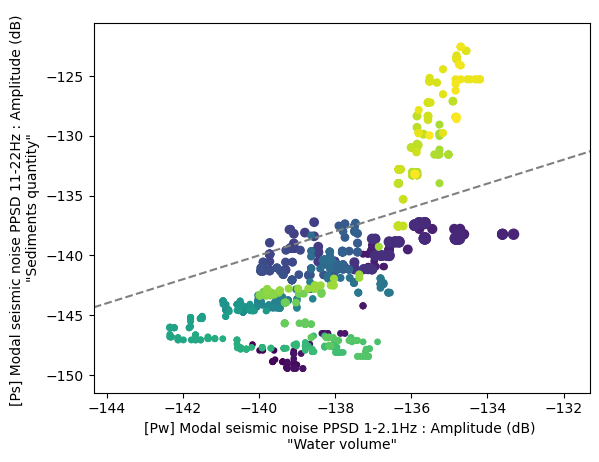

In [56]:
plt.scatter(sPwater[2],sPsed[2], c=Tdate, s=disPW)
plt.xlabel('[Pw] Modal seismic noise PPSD 1-2.1Hz : Amplitude (dB) \n"Water volume"')
plt.ylabel('[Ps] Modal seismic noise PPSD 11-22Hz : Amplitude (dB) \n"Sediments quantity"')
plt.plot([-150,-120],[-150,-120], c='grey', linestyle='--')
plt.ylim(np.min(sPsed[2])-2,np.max(sPsed[2])+2)
plt.xlim(np.min(sPwater[2])-2,np.max(sPwater[2])+2)
plt.show()

# Polarization analysis


In [22]:
from obspy.signal.polarization import polarization_analysis

In [31]:
stN = obspy.read(rot+'4530%s.3.2022.05.08.00.00.00.000.N.miniseed'%stt)
stE = obspy.read(rot+'4530%s.3.2022.05.08.00.00.00.000.E.miniseed'%stt)
stZ = obspy.read(rot+'4530%s.3.2022.05.08.00.00.00.000.Z.miniseed'%stt)
#inv = read_inventory("/path/to/ffbx.stationxml")

In [38]:
endtime = stN[0].stats.endtime
stttime = stN[0].stats.starttime

In [32]:
stream = obspy.Stream(traces=[stN[0], stE[0],stZ[0]])

In [33]:
stream

3 Trace(s) in Stream:
SS.20773..DPN | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 250.0 Hz, 21600001 samples
SS.20773..DPE | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 250.0 Hz, 21600001 samples
SS.20773..DPZ | 2022-05-08T00:00:00.000000Z - 2022-05-09T00:00:00.000000Z | 250.0 Hz, 21600001 samples

In [ ]:
polarization_analysis(stream,15*60, 0.5,1, 2.1, stttime, endtime, method='vidale')

# Garbage

In [ ]:
#noise_timekal, meanhus25, medianhus25 = perm_amp_noise_mean_median(120, '2022.05.08',2,5)
noise_timekal, meanhus25, medianhus25 = amp_noise_mean_median(root,'453020739.',20, '2022.05.08',2,5)
# = perm_amp_noise_mean_median(120, '2022.05.08',10,20)
noise_timekal, meanhus1020, medianhus1020 = amp_noise_mean_median(root,'453020739.',20, '2022.05.08',10,20)

2022.05.08.00.00.00.000
Days 3 accomplished in 6.390625 seconds
2022.05.09.00.00.00.000
Days 4 accomplished in 6.265625 seconds
2022.05.10.00.00.00.000
Days 5 accomplished in 6.671875 seconds
2022.05.11.00.00.00.000
Days 6 accomplished in 5.46875 seconds
2022.05.12.00.00.00.000
Days 7 accomplished in 6.09375 seconds
2022.05.13.00.00.00.000
Days 8 accomplished in 5.453125 seconds
2022.05.14.00.00.00.000
Days 9 accomplished in 6.171875 seconds
2022.05.15.00.00.00.000
Days 10 accomplished in 5.46875 seconds
2022.05.16.00.00.00.000
Days 11 accomplished in 5.96875 seconds
2022.05.17.00.00.00.000
Days 12 accomplished in 6.0 seconds
2022.05.18.00.00.00.000
Days 13 accomplished in 6.484375 seconds
2022.05.19.00.00.00.000
Days 14 accomplished in 5.875 seconds
2022.05.20.00.00.00.000
Days 15 accomplished in 6.984375 seconds
2022.05.21.00.00.00.000
Days 16 accomplished in 7.65625 seconds
2022.05.22.00.00.00.000
Days 17 accomplished in 6.90625 seconds
2022.05.23.00.00.00.000
Days 18 accomplished i

ValueError: too many values to unpack (expected 3)

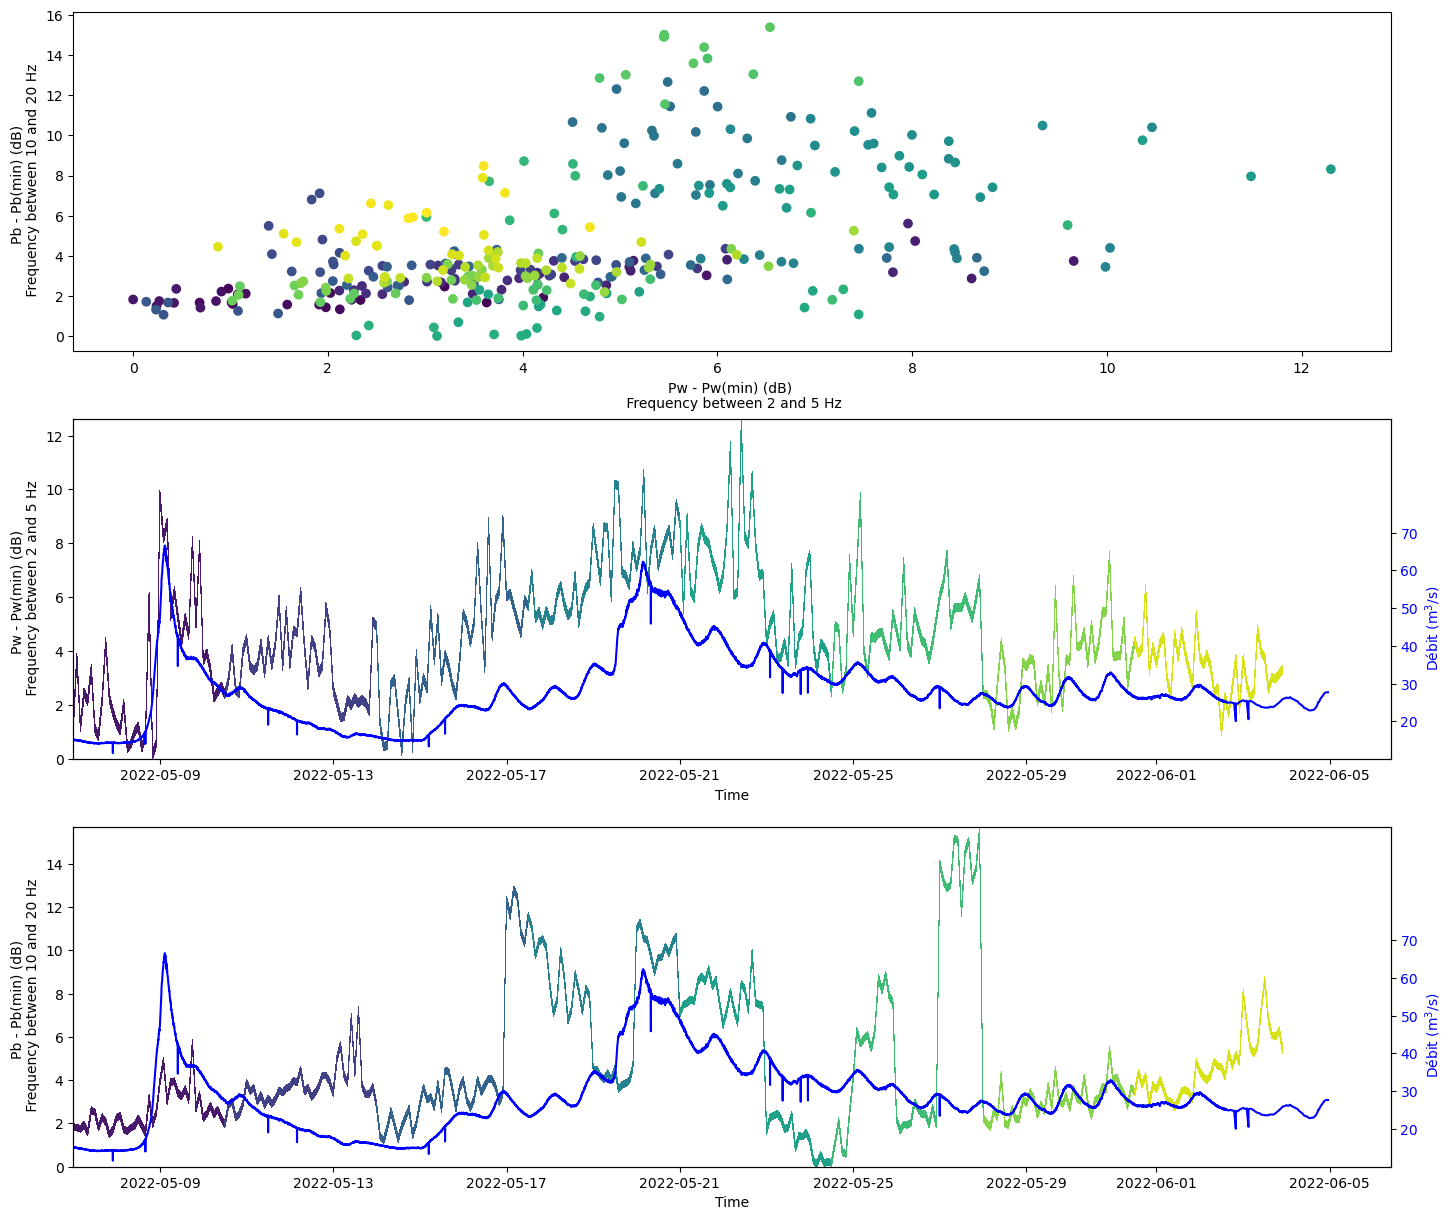

In [ ]:
pw_pb(medianhus25, medianhus1020, noise_timekal,gauging_time, gauging_velos, 28, 'hus_Z')

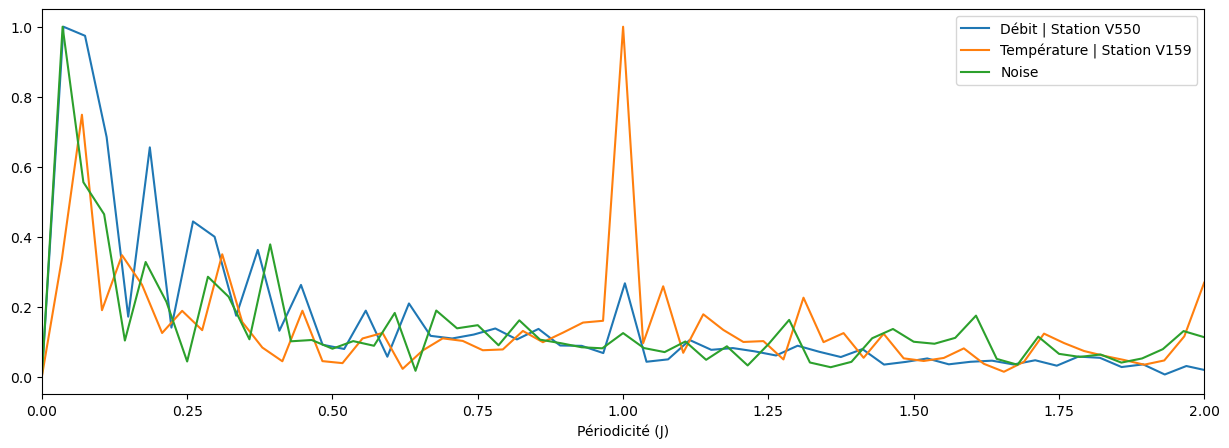

In [36]:
period_temp_discharge_noise(temp, 288, gauging_velos, 288, medianhus25, 12)

In [ ]:
max_velos = np.amax(gauging_velos)
min_velos = np.amin(gauging_velos)
normalise_velos = (gauging_velos - min_velos)/(max_velos-min_velos)*1000

max_temp = np.amax(temp)
min_temp = np.amin(temp)
normalise_temp = (temp - min_temp)/(max_temp-min_temp)*500

fig = plt.subplots(3, 1, figsize=(15, 15))
ax1 = plt.subplot(3, 1, 1)


ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
    
ax2.set_ylabel('Temperature (°C)'+24*' ', color = 'red')
ax2.set_ylim((12,17))
ax2.set_yticks([12.5,13,13.5,14,14.5,15])
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red', linestyle='--')
ax2.tick_params(axis ='y', labelcolor = 'red') 


plt.subplot(3, 1, 2)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(gauging_time,normalise_velos, label = 'Débit normalise 0-1000 | Station V550', c='darkgreen')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.subplot(3, 1, 3)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(temp_time,normalise_temp, label = 'Temperature normalise 0-500 | Station V159', c='red',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.show()



In [ ]:
file_precip = '\\PRECIP\\04176099999.csv'
starttime = '2022-05-07'
start = 0

precip_time = []
precip = []

with open(direct+file_precip) as file :
    readcsv = csv.reader(file, delimiter=',')
    line = 0
    for row in readcsv :
        if line > 0 :
            print(row[aa1])
        if line == 0 :
            aa1 = row.index('AA1')
            date = row.index('DATE')
        elif line > 0 and row[date][0:10] == starttime :
            print(row[date][0:10])
            start = 1
        elif start == 1 :
            precip_time.append(datetime.datetime.strptime(row[date],'%Y-%m-%dT%H:%M:%S'))
            precip.append(float(row[aa1][3:7]))
        line += 1


In [12]:
def perm_amp_noise_mean_median(window_size, startdate, lowpass, highpass) :
    
    root = "D:\\permanent\\hus\\HHZ.D\\"

    startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')
    daynumber = startdate - datetime.datetime.strptime('2022.01.01', '%Y.%m.%d')
    daynumber = int(daynumber.total_seconds()/(24*60*60))

    startnumber = 3
    days = 31 - startnumber

    median = []
    mean = []

    for day in range(days) :
        start = time.process_time()
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.%H.%M.%S.000")
        print(datetimeStr)
        trace = obspy.read(root+'VI.hus..HHZ.D.2022.'+str(daynumber+day))
        if day == 0 :
            starttime = str(trace[0].stats.starttime)
            starttime = datetime.datetime.strptime(starttime, '%Y-%m-%dT%H:%M:%S.770000Z')
            noise_time = [starttime]

        window = 24*60/window_size
        
        trace.filter('lowpass', freq=lowpass).filter('highpass', freq=highpass)
        
        trace = np.array(trace[0])

        trace = np.abs(trace)


        npts_p_min = int(len(trace)/(24*60))


        for i in range(int(window)) :
            t0 = i*npts_p_min
            t1 = npts_p_min + i*npts_p_min
            array = trace[t0:t1]
            mean.append(np.mean(array))
            median.append(np.median(array))
            if i > 0 and day == 0 :
                noise_time.append(noise_time[i-1]+datetime.timedelta(minutes=window_size))
            elif day > 0 :
                base = int(day*window)
                noise_time.append(noise_time[base+i-1]+datetime.timedelta(minutes=window_size))
        end = time.process_time() 
        print('Days '+str(day+startnumber)+' accomplished in '+str(end-start)+' seconds')
    return noise_time, mean, median